In [1]:
from pathlib import Path
from pprint import pformat, pprint
import logging
import json
import re
import sys
from math import ceil
from itertools import repeat, chain
import traceback

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import dynamic_yaml
import yaml

logging.basicConfig(format='%(levelname)-8s [%(filename)s] %(message)s',
                    level=logging.DEBUG)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
%load_ext pycodestyle_magic

time: 420 ms (started: 2023-03-06 23:22:23 +08:00)


# Find the most differ graph

In [2]:
sys.path.append("/workspace/correlation-change-predict/ywt_library")
current_dir = Path(__file__).parent
data_config_path = current_dir/"../config/data_config.yaml"
with open(data_config_path) as f:
    data = dynamic_yaml.load(f)
    data_cfg = yaml.full_load(dynamic_yaml.dump(data))

# ## Data implement & output setting & testset setting
# data implement setting
data_implement = "SP500_20082017_CORR_SER_REG_CORR_MAT_HRCHY_11_CLUSTER"  # watch options by operate: logging.info(data_cfg["DATASETS"].keys())
# train set setting
train_items_setting = "-train_train"  # -train_train|-train_all
# setting of name of output files and pictures title
output_file_name = data_cfg["DATASETS"][data_implement]['OUTPUT_FILE_NAME_BASIS'] + train_items_setting
# setting of output files
logging.info(f"===== file_name basis:{output_file_name} =====")
graph_data_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-graph_data"
graph_arr = np.load(graph_data_dir/f"corr_s1_w10_graph.npy")  # each graph consist of 66 node & 66^2 edges

stride = 12
train_arr = graph_arr[:int(len(graph_arr)*0.9)]
val_arr = graph_arr[int(len(graph_arr)*0.9):int(len(graph_arr)*0.95)]
test_arr = graph_arr[int(len(graph_arr)*0.95):]
train_diff_arr = train_arr[stride:] - train_arr[:-stride] # this is what I want
max_diff_ind = np.argmax(train_diff_arr.sum(axis=1).sum(axis=1))
logging.info(f"train_arr.shape: {train_arr.shape}")
logging.info(f"train_diff_arr.shape: {train_diff_arr.shape}")
logging.info(f"train_arr[0][0][:5]: \n{train_arr[0][0][:5]}")
logging.info(f"max_difference index of train_arr: {max_diff_ind}")
logging.info(f"train_diff_arr[{max_diff_ind}][0]: \n{train_diff_arr[max_diff_ind][0]}")
logging.info(f"train_arr[{max_diff_ind}][0]: \n{train_arr[max_diff_ind][0]}")
logging.info(f"train_arr[{max_diff_ind+stride}][0]: \n{train_arr[max_diff_ind+stride][0]}")

INFO     [2586445745.py] ===== file_name basis:sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train =====
INFO     [2586445745.py] train_arr.shape: (2247, 66, 66)
INFO     [2586445745.py] train_diff_arr.shape: (2235, 66, 66)
INFO     [2586445745.py] train_arr[0][0][:5]: 
[ 1.         -0.7845055  -0.35839325  0.23613496  0.03113716]
INFO     [2586445745.py] max_difference index of train_arr: 1902
INFO     [2586445745.py] train_diff_arr[1902][0]: 
[ 0.          1.0869076   0.80756148  1.10147876  0.27583836  1.4311462
  0.31798946  0.77423705  1.49131504  0.06400973  0.35000056  1.02577531
  1.54352727  1.31498903  0.71837798  1.37400844  0.53681407  1.7463089
  1.50096265  0.55053766  0.14724983  1.23417145  1.64226315  1.54879715
  1.8150735   1.3664364   1.2108747   0.38212797  0.62011885  1.26466605
  0.10248986  1.46270668  0.23049925  0.21841866  1.6698941   1.70031337
  1.75067461  1.8054871   0.2055773   0.15378154  0.24515754  0.01484384
  1.7717906   1.38432037  0.

time: 163 ms (started: 2023-03-06 23:22:23 +08:00)


# Draw the training process

In [3]:
def mts_corr_ad_tr_proc_est(log_path_list: list, condition_dict: dict):
    try:
        df = pd.DataFrame()
        for log_path in log_path_list:
            with open(log_path, "r") as source:
                log_dict = json.load(source)

            corr_info = str(next(filter(lambda p: p.startswith("corr"), log_path.parts)))
            best_epoch_n = log_dict.get('best_val_epoch', 500)
            tr_batch = log_dict.get('train_batch')
            batchs_per_epoch_n = log_dict.get('batchs_per_epoch', 0)
            loss_his_dict = {"tr_loss": log_dict.get('train_loss_history', [0]), "val_loss": log_dict.get('val_loss_history', [0])}
            min_tr_loss, min_val_loss = min(loss_his_dict["tr_loss"]), min(loss_his_dict["val_loss"])

            if model_struct_str := log_dict.get('model_structure'):
                gra_enc_l = len(re.findall("\(\d\)\:\s.*Conv", model_struct_str))
                gra_enc_h = int(re.search("(\(\d\)\:\s.*Conv.*\n.*)(out_features\=)(\d*)", model_struct_str).group(3))
                gru_l = int(re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", model_struct_str)[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", model_struct_str) else 1)
                gru_h = int(re.search("(\(gru1\)\:\sGRU\(\d*\,)\s(\d*)", model_struct_str).group(2))
            else:
                gra_enc_l, gra_enc_h, gru_l, gru_h = [None] * 4

            if embeds_history := log_dict.get("graph_embeds_history"):
                pred_embeds_history = embeds_history.get('graph_embeds_pred', [0])
                y_embeds_history = embeds_history.get('graph_embeds_pred', [0])
                embeds_his_dict = {"pred_embeds": np.array(pred_embeds_history[:batchs_per_epoch_n * 2]\
                                                               + [([np.nan] * (gra_enc_l * gra_enc_h)) for _ in range(20)]\
                                                               + pred_embeds_history[-batchs_per_epoch_n * 2:]),
                                   "y_embeds": np.array(y_embeds_history[:batchs_per_epoch_n * 2]\
                                                        + [([np.nan] * (gra_enc_l * gra_enc_h)) for _ in range(20)]\
                                                        + y_embeds_history[-batchs_per_epoch_n * 2:]),
                                   "last_y_embeds": y_embeds_history[-batchs_per_epoch_n * 5:]}
            else:
                continue
                # embeds_his_dict = {"pred_embeds": [0], "y_embeds": [0], "last_y_embeds": [0]}

            assert not(set(condition_dict.keys()) - set(locals().keys())), "one of condition_dict.keys() doesn't match the local variables if mts_corr_ad_est()"
            est_values_dict = locals()
            filtered_dict = dict(filter(lambda x: est_values_dict[x[0]] == x[1], condition_dict.items()))
            if filtered_dict == condition_dict:
                main_title_str = f'{corr_info} with tr_batch({tr_batch}) input to model with gra_enc_l{gra_enc_l}-gra_enc_h{gra_enc_h}-gru_l{gru_l}-gru_h{gru_h}; min val-loss:{min_val_loss:8f}'
                logging.info(f"file_name:{log_path.parts[-1]}")
                logging.info(f"file_path:{log_path.parts[2:-2]}")
                logging.info(main_title_str)
                comparison_dict = dict(filter(lambda x: x[0] in ["corr_info", "tr_batch", "gra_enc_l", "gra_enc_h", "gru_l", "gru_h", "min_tr_loss", "min_val_loss"], locals().items()))
                df = pd.concat([df, pd.DataFrame([comparison_dict])])
                plot_mts_corr_ad_tr_process(main_title=main_title_str, model_struct=model_struct_str,
                                            loss_history=loss_his_dict, embeds_history=embeds_his_dict,
                                            best_epoch=best_epoch_n, batchs_per_epoch=batchs_per_epoch_n)
            else:
                continue
        else:
            df = df.reindex(["corr_info", "tr_batch", "gru_l", "gru_h", "gra_enc_l", "gra_enc_h", "min_tr_loss", "min_val_loss"], axis=1)
            df = df.sort_values(["gra_enc_l", "gra_enc_h", "tr_batch", "gru_l", "gru_h"], ascending=False)
            display(df)
    except Exception as e:
        error_class = e.__class__.__name__ #⬞取得錯誤類型
        detail = e.args[0]  #⬞取得詳細內容
        cl, exc, tb = sys.exc_info() #⬞取得Call⬞Stack
        last_call_stack = traceback.extract_tb(tb)[-1] #⬞取得Call⬞Stack的最後一筆資料↵
        file_name = last_call_stack[0] #⬞取得發生的檔案名稱↵
        line_num = last_call_stack[1] #⬞取得發生的行號↵
        func_name = last_call_stack[2] #⬞取得發生的函數名稱
        err_msg = "File \"{}\", line {}, in {}: [{}] {}".format(file_name, line_num, func_name, error_class, detail)
        logging.error(f"file:{log_path.parts[-1]}, path:{log_path}")
        logging.error(f"===\n{err_msg}")
        logging.error(f"===\n{traceback.extract_tb(tb)}")


def plot_mts_corr_ad_tr_process(main_title: str, model_struct: str, loss_history: dict, embeds_history: dict, best_epoch: int, batchs_per_epoch: int):
    pred_embeds, y_embeds, last_y_embeds = embeds_history['pred_embeds'], embeds_history['y_embeds'], embeds_history['last_y_embeds']
    max_batch = batchs_per_epoch * len(loss_history['tr_loss'])  # epochs == len(loss_history['tr_loss'])
    line_style = {"linewidth": 2, "alpha": 0.5}
    axvline_style = {"color": 'k', "linewidth": 5, "linestyle": '--', "alpha": 0.3}
    fig, axs = plt.subplots(ncols=2, nrows=7, figsize=(25,50))
    fig.suptitle(main_title, fontsize=30)
    gs = axs[0, 0].get_gridspec()
    xticks_intv = {"loss": 20,
                   "fr_ls_embeds": int(len(y_embeds)/10)}
    loss_xticks_label = list(range(max(0, best_epoch-100), max(201, best_epoch+101), xticks_intv["loss"]))
    fr_ls_embeds_xticks_label = list(range(0, batchs_per_epoch*2, xticks_intv["fr_ls_embeds"])) + [" "] + list(range(max_batch-xticks_intv["fr_ls_embeds"]*4, max_batch+1, xticks_intv["fr_ls_embeds"]))
    data_info_dict = [{"sub_title": 'train_loss_history',
                       "data": loss_history['tr_loss'],
                       "xticks": None,
                       "xlabel": "epochs"},
                      {"sub_title": 'val_loss_history',
                       "data": loss_history['val_loss'],
                       "xticks": None,
                       "xlabel": "epochs"},
                      {"sub_title": f"train_loss_history-epoch{(max(0, best_epoch-100), max(200, best_epoch+100))}",
                       "data": loss_history['tr_loss'][max(0, best_epoch-100):max(201, best_epoch+101)],
                       "xticks": {"label": loss_xticks_label, "intv": xticks_intv['loss']},
                       "xlabel": "epochs"},
                      {"sub_title": f"val_loss_history-epoch{(max(0, best_epoch-100), max(200, best_epoch+100))}",
                       "data": loss_history['val_loss'][max(0, best_epoch-100):max(201, best_epoch+101)],
                       "xticks": {"label": loss_xticks_label, "intv": xticks_intv['loss']},
                       "xlabel": "epochs"},
                      {"sub_title": f'pred_embeds, embeds size:[{pred_embeds.shape[1]}]',
                       "data": pred_embeds,
                       "xticks": {"label": fr_ls_embeds_xticks_label, "intv": xticks_intv["fr_ls_embeds"]},
                       "xlabel": "batchs",
                       "axvline": (batchs_per_epoch, batchs_per_epoch*3+20)},
                      {"sub_title": f'y_embeds, embeds size:[{y_embeds.shape[1]}]',
                       "data": y_embeds,
                       "xticks": {"label": fr_ls_embeds_xticks_label, "intv": xticks_intv["fr_ls_embeds"]},
                       "xlabel": "batchs",
                       "axvline": (batchs_per_epoch, batchs_per_epoch*3+20)}]
    for ax, data_plot in zip(axs.ravel(), data_info_dict) :
        ax.plot(data_plot["data"], **line_style)
        ax.set_title(data_plot["sub_title"], fontsize=30)
        ax.yaxis.offsetText.set_fontsize(18)
        ax.tick_params(axis='both', which='major', labelsize=24)
        if pos_tuple := data_plot.get("axvline"):
            for x_pos in pos_tuple:
                ax.axvline(x=x_pos, **axvline_style)
        if xlabel := data_plot.get("xlabel"):
            ax.set_xlabel(xlabel, fontsize=24)
        if t := data_plot.get("xticks"):
            ax.set_xticks(ticks=range(0, len(t["label"])*t["intv"], t["intv"]), labels=t["label"], rotation=45)

    # remove the upper axes
    for ncol in range(2):
        for ax in axs[3:, ncol]:
            ax.remove()
    ax_last_y_embeds =fig.add_subplot(gs[3, :2])
    ax_last_y_embeds.plot(last_y_embeds, **line_style)
    ax_last_y_embeds.set_title(f"y_embeds in last five epochs; embeds size:{y_embeds.shape[1]}", fontsize=30)
    ax_last_y_embeds.set_xticks(ticks=range(0, batchs_per_epoch * 5 + 1, batchs_per_epoch) ,labels=range(max_batch - batchs_per_epoch * 5, max_batch + 1, batchs_per_epoch))
    ax_last_y_embeds.set_xlabel("batchs", fontsize=24)
    ax_last_y_embeds.tick_params(axis='both', which='major', labelsize=24)
    [ax_last_y_embeds.axvline(x=i*batchs_per_epoch, **axvline_style) for i in range(1,5)]
    ax_model_anno = fig.add_subplot(gs[4:, :2])
    ax_model_anno.set_xticks([]); ax_model_anno.set_yticks([])
    ax_model_anno.annotate(text=f"{str(model_struct)}",
                           xy=(0.15, 0.5), bbox={'facecolor': 'green', 'alpha': 0.4, 'pad': 5},
                           fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
    fig.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()
    plt.close()

time: 4.79 ms (started: 2023-03-06 23:22:24 +08:00)


INFO     [72079487.py] file_name:epoch_213-20230306044613.json
INFO     [72079487.py] file_path:('corr_s1_w10',)
INFO     [72079487.py] corr_s1_w10 with tr_batch(32) input to model with gra_enc_l5-gra_enc_h64-gru_l1-gru_h8; min val-loss:108399.710938


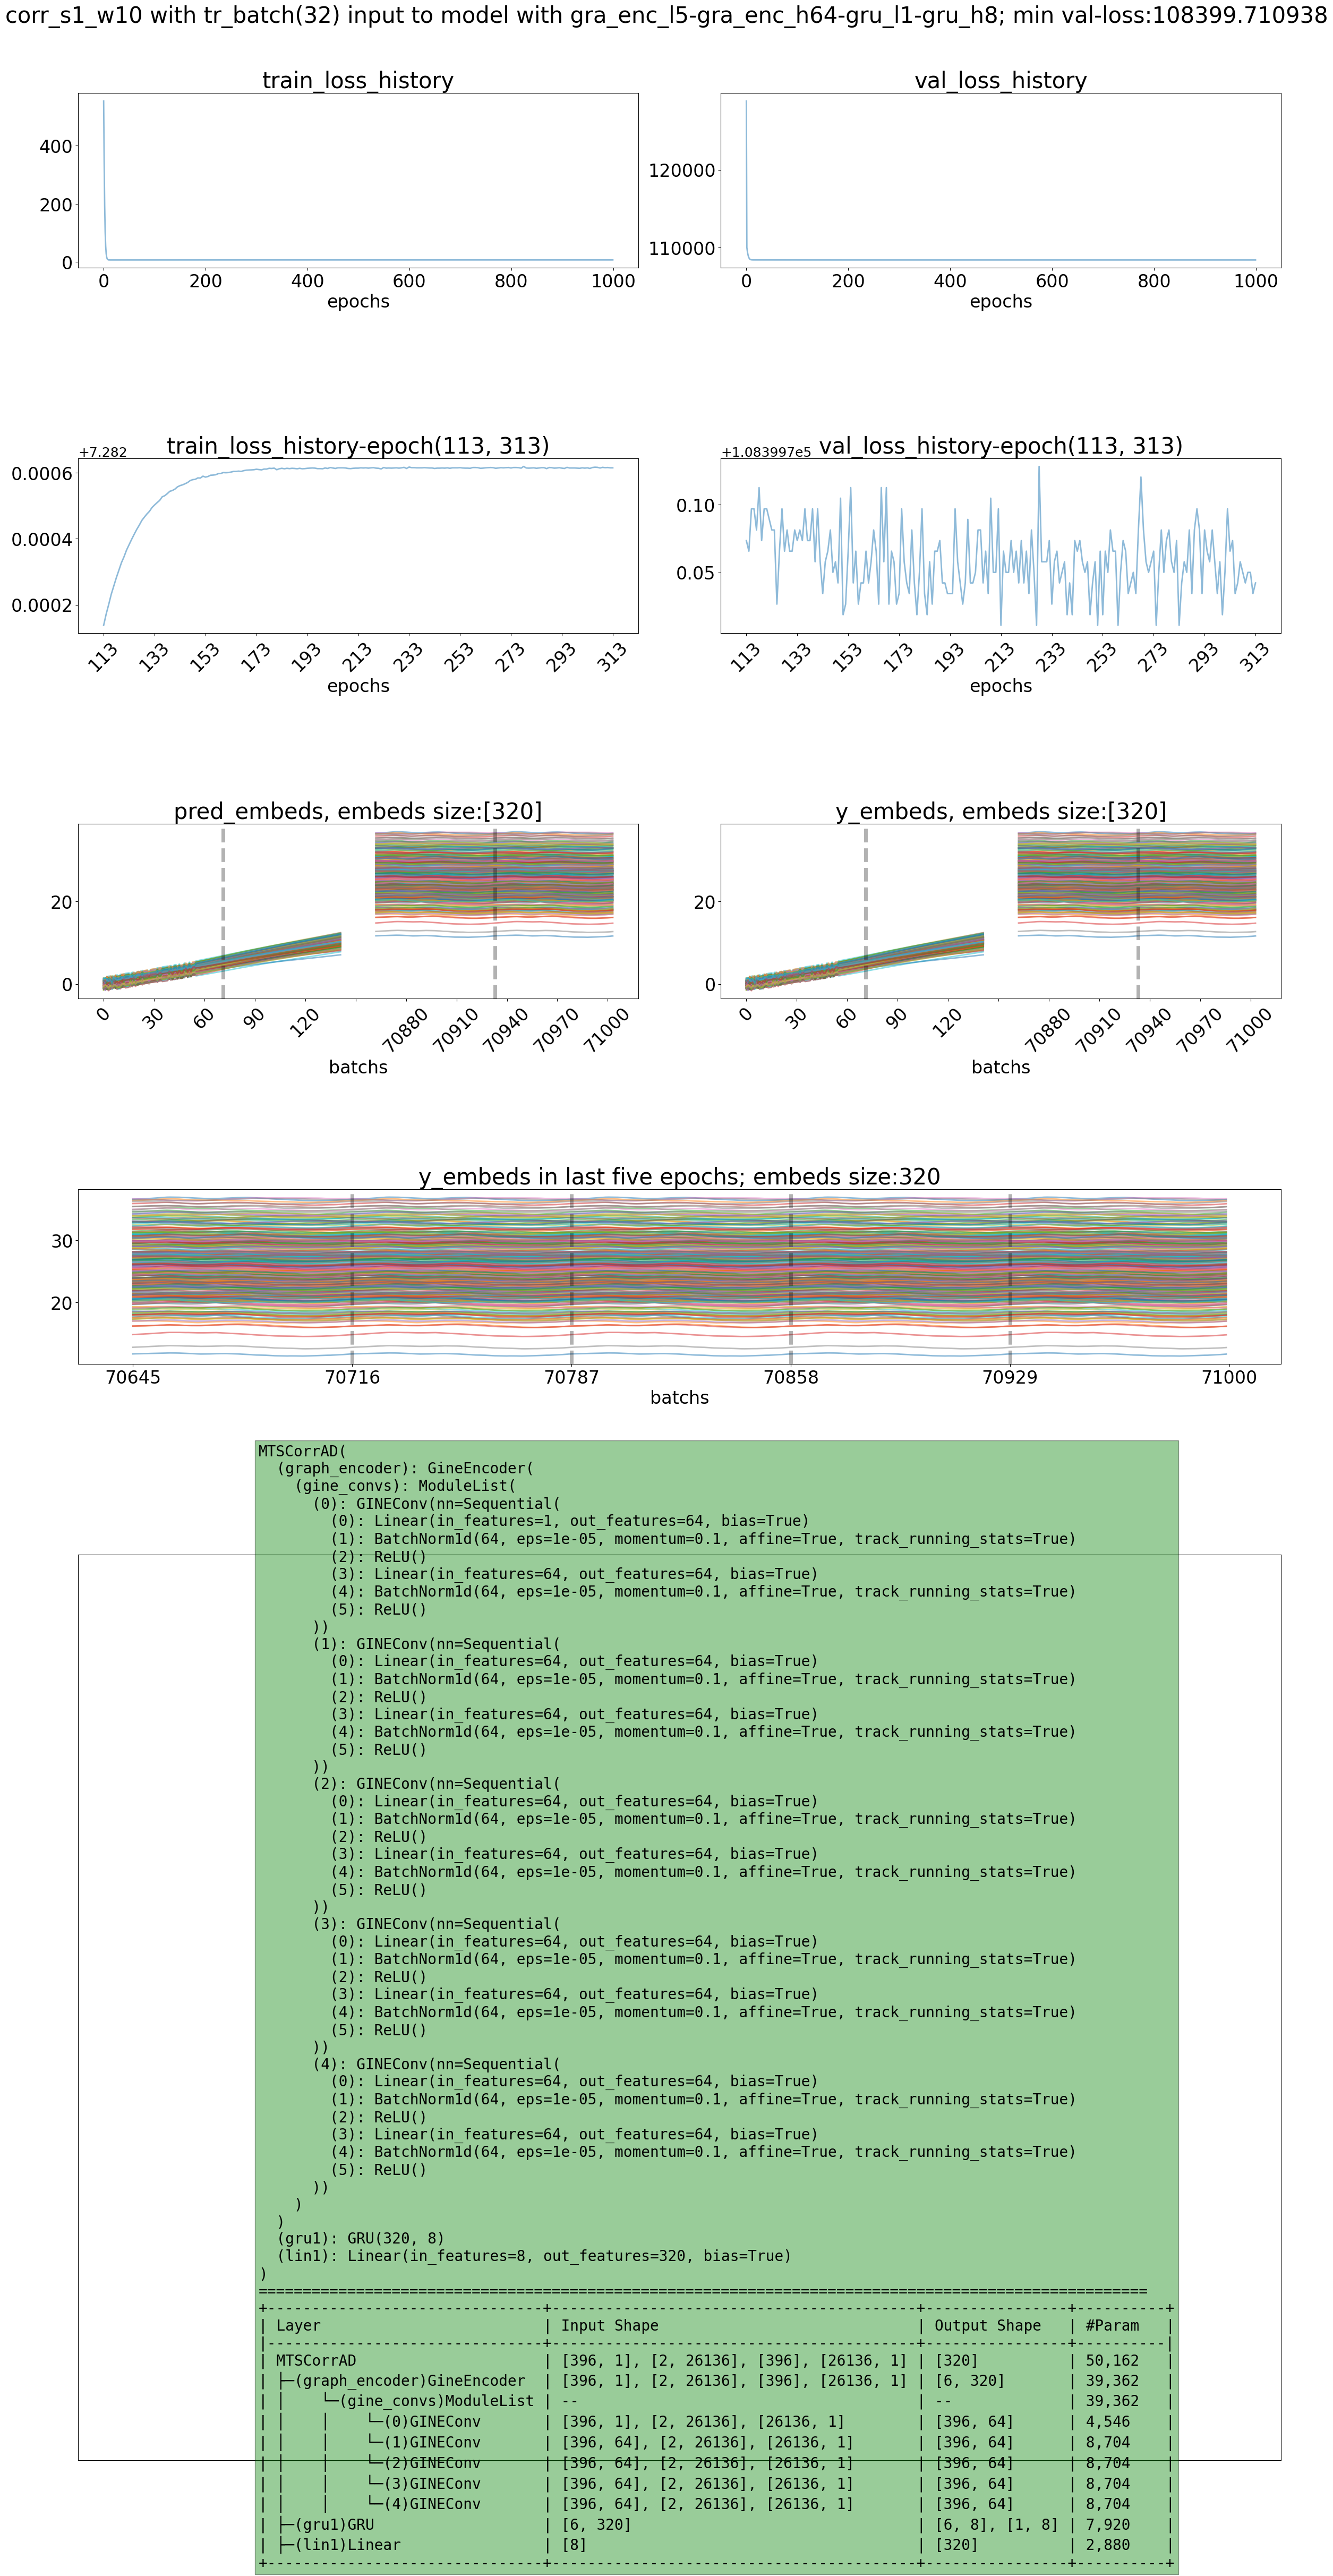

INFO     [72079487.py] file_name:epoch_985-20230306084054.json
INFO     [72079487.py] file_path:('corr_s1_w10',)
INFO     [72079487.py] corr_s1_w10 with tr_batch(128) input to model with gra_enc_l5-gra_enc_h64-gru_l1-gru_h8; min val-loss:128559.570312


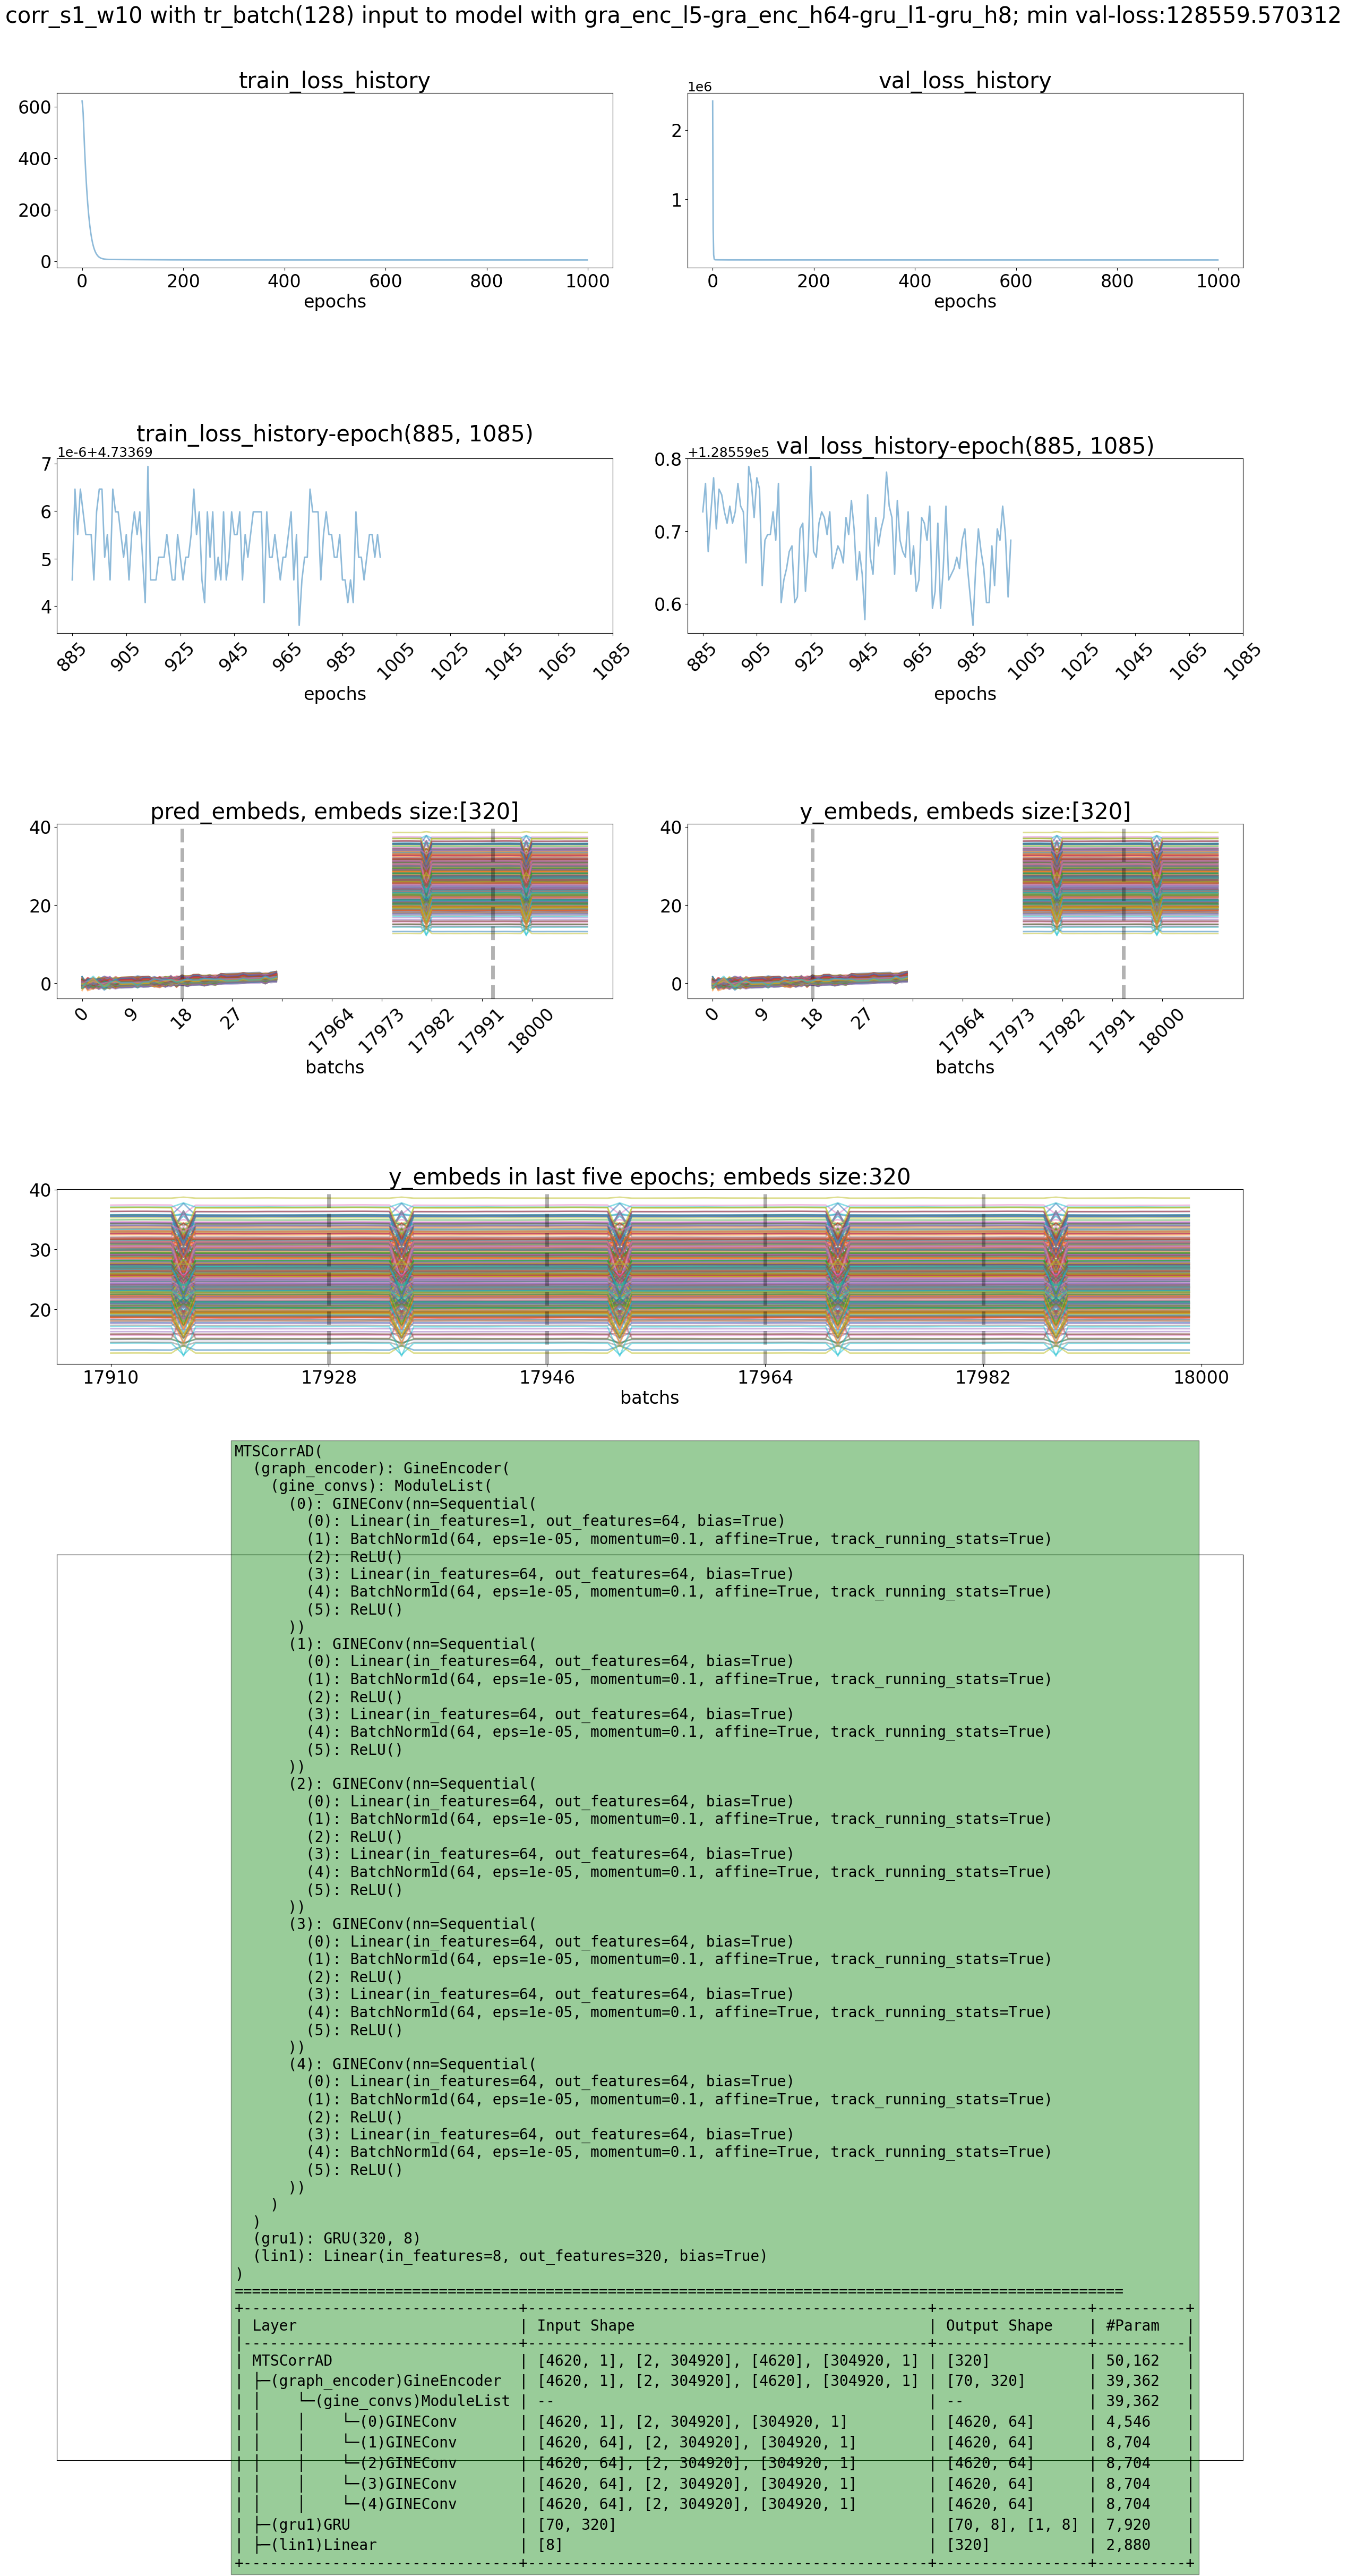

INFO     [72079487.py] file_name:epoch_997-20230306192557.json
INFO     [72079487.py] file_path:('corr_s1_w10',)
INFO     [72079487.py] corr_s1_w10 with tr_batch(32) input to model with gra_enc_l5-gra_enc_h64-gru_l3-gru_h8; min val-loss:193778.640625


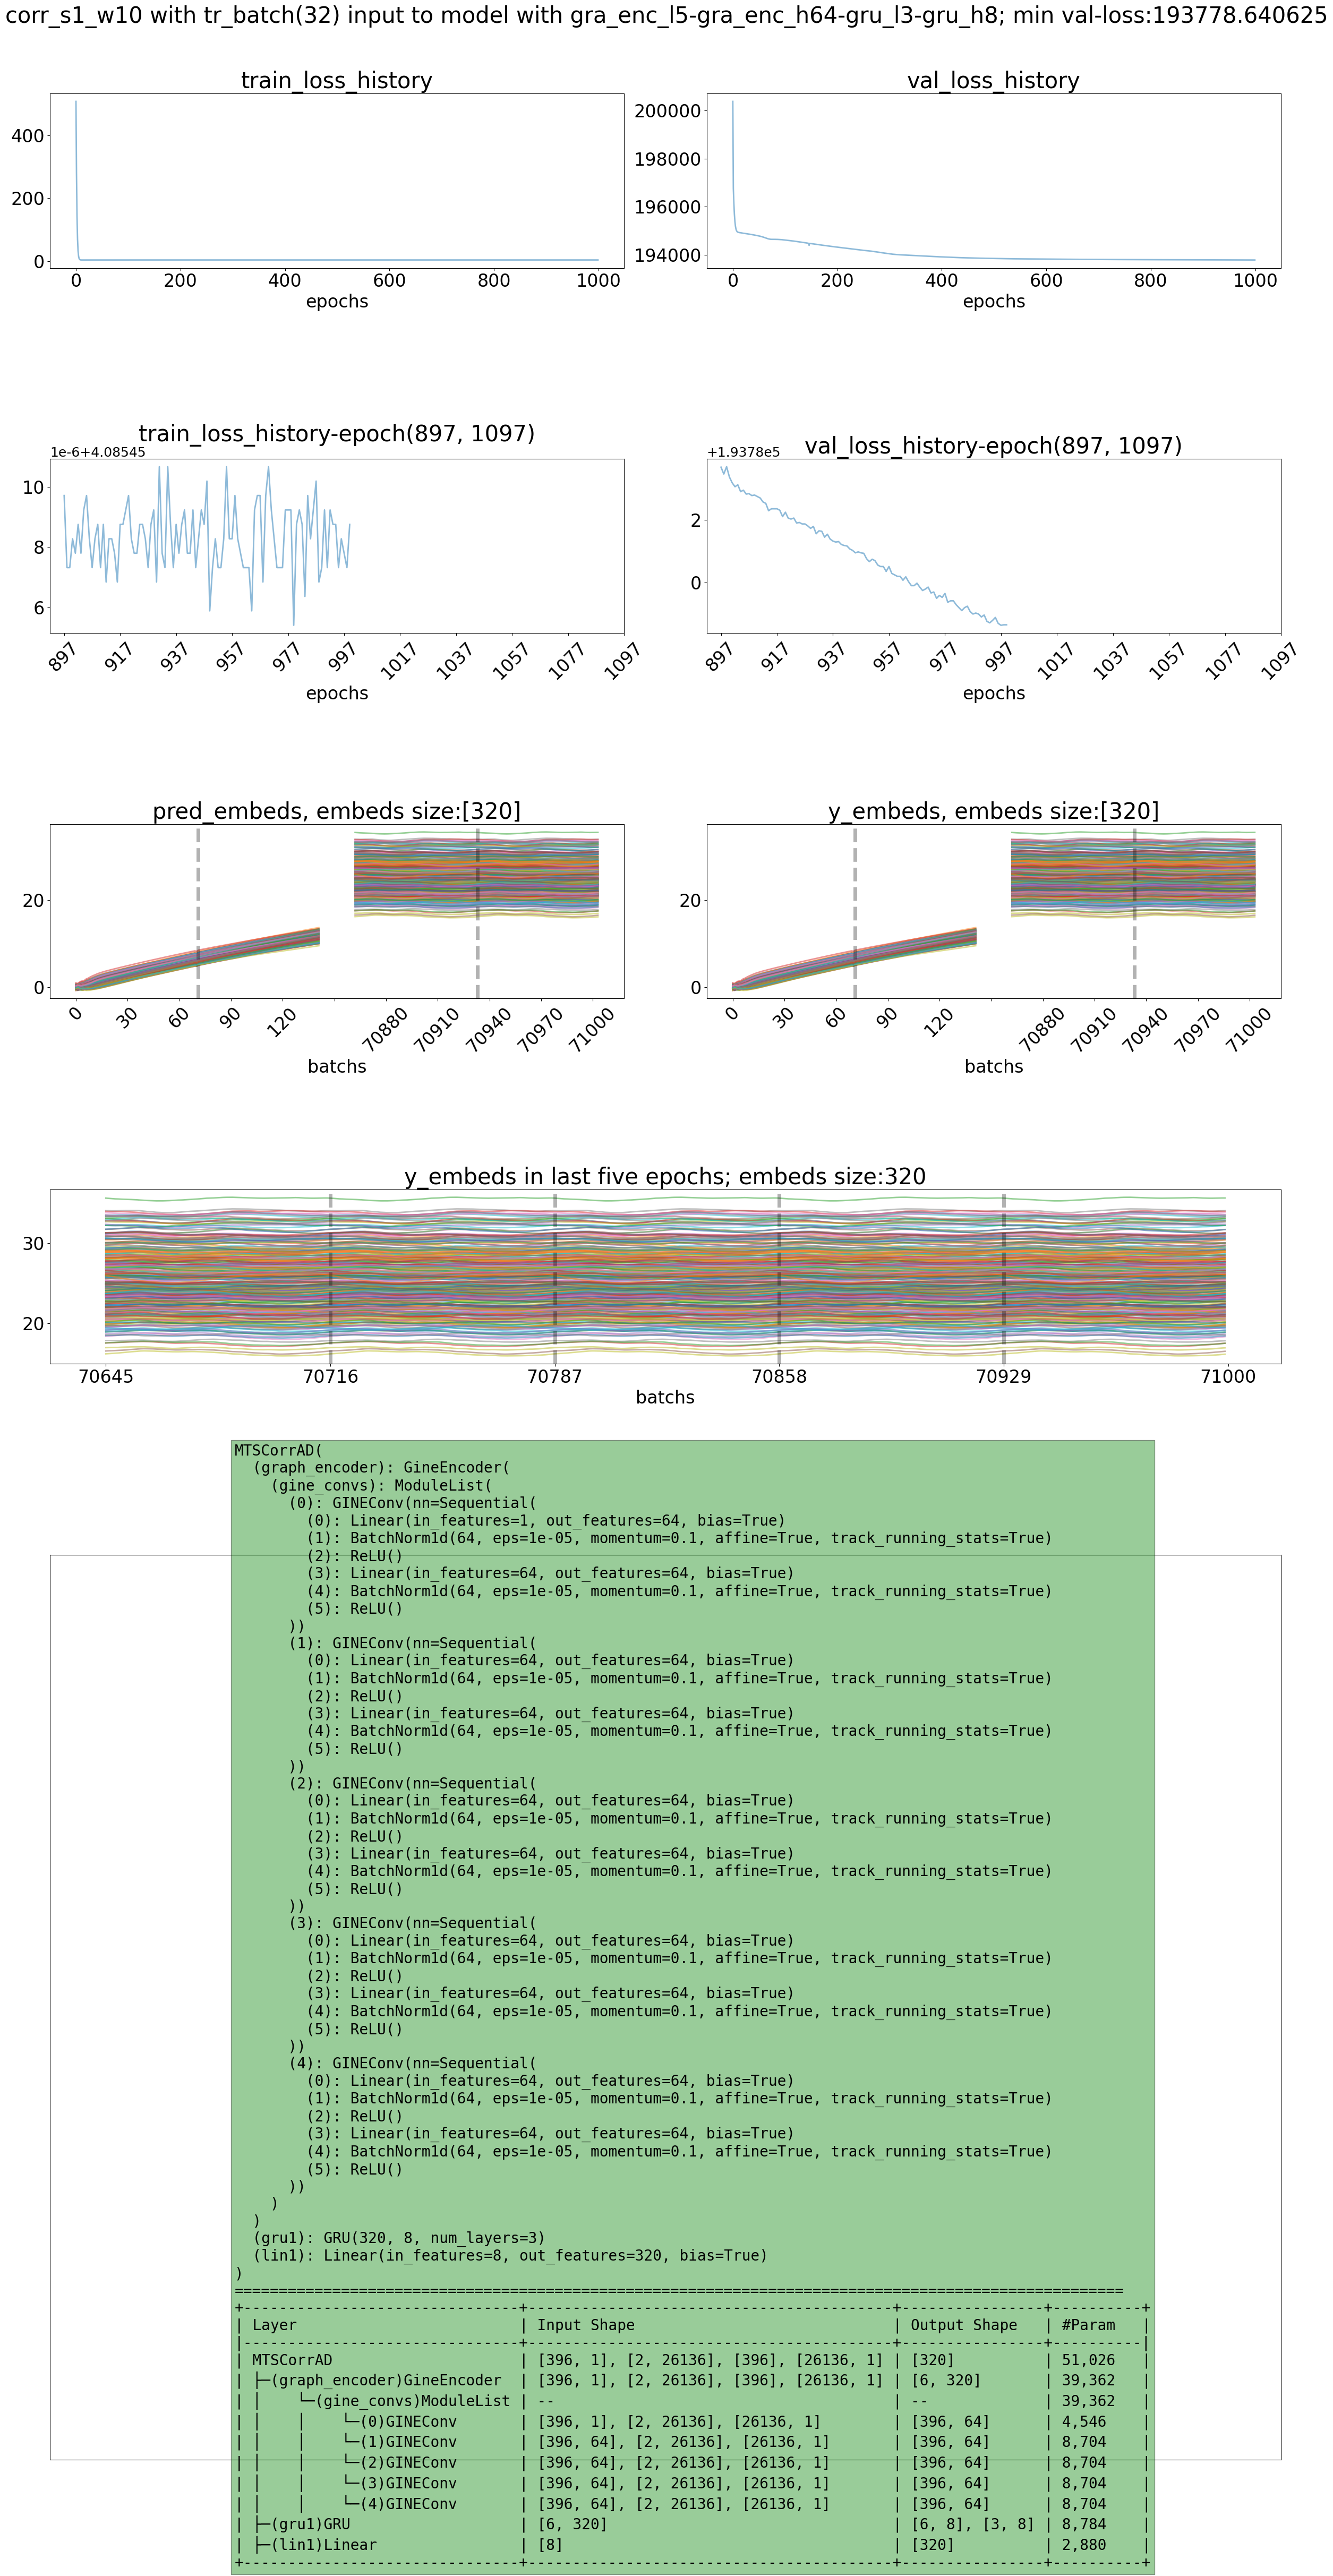

corr_info  tr_batch  gru_l  gru_h  gra_enc_l  gra_enc_h  min_tr_loss  \
0  corr_s1_w10       128      1      8          5         64     4.733694   
0  corr_s1_w10        32      3      8          5         64     3.987086   
0  corr_s1_w10        32      1      8          5         64     7.161333   

    min_val_loss  
0  128559.570312  
0  193778.640625  
0  108399.710938

time: 48.3 s (started: 2023-03-06 23:39:50 +08:00)


In [9]:
mts_corr_model_log_dir = Path("./save_models/sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train/")
log_path_list1 = mts_corr_model_log_dir.glob("./*[!deprecated][!.ipynb_checkpoints]*/train_logs/*[!.ipynb_checkpoints]*[.json]")
log_path_list2 = mts_corr_model_log_dir.glob("./*[archive][!deprecated]*/**/train_logs/*[!.ipynb_checkpoints]*[.json]")
log_path_list3 = mts_corr_model_log_dir.glob("./**/train_logs/*[!.ipynb_checkpoints]*[.json]")


# mts_corr_ad_vis(log_path_list1, {"corr_info": "corr_s1_w10", "tr_batch": 12, "gra_enc_h": 4})
mts_corr_ad_tr_proc_est(log_path_list1, {"corr_info": "corr_s1_w10", "gra_enc_l":5, "gra_enc_h":64})

In [5]:
specific_log_p = mts_corr_model_log_dir/f"corr_s1_w10/train_logs/epoch_251-20230305215527.json"

with open(specific_log_p, "r") as source:
    log_dict = json.load(source)

if log_dict.get('model_structure'):
    gin_l = len(re.findall("\(\d\)GINConv", log_dict.get('model_structure')))
    gin_h = int(re.search("(\(\d\)\:\sGINConv.*\n.*)(out_features\=)(\d*)", log_dict.get('model_structure')).group(3))
    gru_l = int(re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure'))[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure')) else 1)
    gru_h = int(re.search("(\(gru1\)\:\sGRU\(\d*\,)\s(\d*)", log_dict.get('model_structure')).group(2))
else:
    gin_l = None
    gin_h = None
    gru_l = None
    gru_h = None
corr_info = [p for p in specific_log_p.parts if p.startswith("corr")][0]
best_epoch = log_dict['best_val_epoch'] if log_dict.get('best_val_epoch') else 500
min_val_loss = min(log_dict['val_loss_history'])
tr_batch = log_dict.get('train_batch') if log_dict.get('train_batch') else None
batchs_per_epoch = log_dict.get('batchs_per_epoch')
tr_loss = log_dict.get('train_loss_history')
val_loss = log_dict.get('val_loss_history')
pred_embeds = np.array(log_dict.get('graph_embeds_history').get('graph_embeds_pred')[:batchs_per_epoch*2]\
                       + [([np.nan]*(gin_l*gin_h)) for _ in range(20)]\
                       + log_dict.get('graph_embeds_history').get('graph_embeds_pred')[-batchs_per_epoch*2:])
y_embeds = np.array(log_dict.get('graph_embeds_history').get('y_graph_embeds')[:batchs_per_epoch*2]\
                    + [([np.nan]*(gin_l*gin_h)) for _ in range(20)]\
                    + log_dict.get('graph_embeds_history').get('y_graph_embeds')[-batchs_per_epoch*2:])
plt.figure(figsize=(14.5, 8))
plt.plot(y_embeds, linewidth=5, alpha=0.3)
plt.axvline(x=batchs_per_epoch, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                  color='k', linewidth=5, linestyle='--', alpha=0.3)
plt.axvline(x=batchs_per_epoch*3+20, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                  color='k', linewidth=5, linestyle='--', alpha=0.3)
plt.annotate(text=f"188", xy=(0.19, 0.5),
             bbox={'facecolor': 'gray', 'alpha': 0.4, 'pad': 5},
             fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
plt.annotate(text=f"187811", xy=(0.77, 0.5),
             bbox={'facecolor': 'gray', 'alpha': 0.4, 'pad': 5},
             fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
plt.title(f'y_embeds-[{y_embeds.shape[1]}]', fontsize=30)
xticks_label = list(range(0, 301, 100)) + list(range(187600, 188001, 100))
plt.xticks(ticks=list(range(0, 801, 100)), labels=xticks_label, fontsize=18)
plt.yticks(fontsize=24)
plt.show()
plt.close()

AttributeError: 'NoneType' object has no attribute 'group'

time: 3.6 s (started: 2023-03-06 23:23:27 +08:00)
